## Librairies et fonctions nécessaires

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.pipeline import Pipeline
import joblib

%matplotlib inline

## Présentation des données

In [6]:
image_count = 0
labels = []
train_counts = []
for dirname in os.listdir('/app/split-garbage-dataset/train'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('/app/split-garbage-dataset/train',dirname)):
        image_count +=1
    train_counts.append(image_count)

print(list(zip(train_counts,labels)))

[(91, 'trash'), (403, 'paper'), (286, 'metal'), (354, 'glass'), (347, 'plastic'), (287, 'cardboard')]


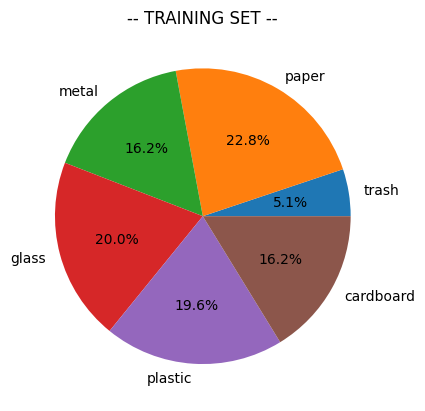

In [7]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=labels,
        autopct='%1.1f%%');
plt.title('-- TRAINING SET --');

In [8]:
class_weights = []
total_samples = 1768
total_classes = 6
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)
print(dict(zip(labels,class_weights)))

class_weights = dict(zip(range(6), class_weights))

{'trash': 3.24, 'paper': 0.73, 'metal': 1.03, 'glass': 0.83, 'plastic': 0.85, 'cardboard': 1.03}


## Augmentation de données

In [9]:
# Ajouter les paramètres de la data augmentée à travers ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                  )

# Or la dataset de validation ne doit pas être augmentée
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

#le générateur train_datagen va générer des données d'entrainement à partir de flows de 8 images
train_generator = train_datagen.flow_from_directory('/app/split-garbage-dataset/train',
                                                    batch_size =8,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))     

# le générateur valid_datagen va générer des données de validation à partir de flows de 4 images
validation_generator =  valid_datagen.flow_from_directory( '/app/split-garbage-dataset/valid',
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150,150))     

# Générer le flow d'images de test avec test_datagen
test_generator = test_datagen.flow_from_directory('/app/split-garbage-dataset/test',
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150),shuffle = False)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## Modèle 1

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model = keras.models.Model(inputs=xception_model.input, outputs=output)

In [17]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.7,patience = 2)
model_checkpoint =tf.keras.callbacks.ModelCheckpoint('GarbageClassifier_Xce.h5', save_best_only=True)

class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.98):
                print("\nReached 98.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
mycallback = CustomCallBack()

In [19]:
history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size,
            class_weight = class_weights ,
            callbacks= [early_stopping_cb,model_checkpoint,lr_scheduler,mycallback],
            verbose=1)

Epoch 1/30
221/221 [==============================] - 581s 3s/step - loss: 1.4571 - accuracy: 0.4610 - val_loss: 12.2834 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - 557s 3s/step - loss: 1.1538 - accuracy: 0.5718 - val_loss: 3.5499 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 3/30
221/221 [==============================] - 568s 3s/step - loss: 1.0046 - accuracy: 0.6267 - val_loss: 1.1585 - val_accuracy: 0.5823 - lr: 0.0010
Epoch 4/30
221/221 [==============================] - 552s 3s/step - loss: 0.8874 - accuracy: 0.6708 - val_loss: 0.9265 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 5/30
221/221 [==============================] - 551s 2s/step - loss: 0.8841 - accuracy: 0.6697 - val_loss: 1.0885 - val_accuracy: 0.6524 - lr: 0.0010
Epoch 6/30
221/221 [==============================] - 567s 3s/step - loss: 0.8378 - accuracy: 0.6900 - val_loss: 1.0544 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 7/30
221/221 [==============================] - 558s 3s/s

In [25]:
# Pipeline
pipeline = Pipeline([
    ('xception1', model)
])

In [28]:
# Save the pipeline to a joblib file
joblib.dump(pipeline, 'xception1_pipeline.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
......activation_24
.........vars
......activation_25
.........vars
......activation_26
.........vars
......activation_27
.........vars
......activation_28
.........vars
......activation_29
.........vars
......activation_3
.........vars
......activation_30
.........vars
......activation_31
.........vars
......activation_32
.........vars
......activa

['xception1_pipeline.joblib']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


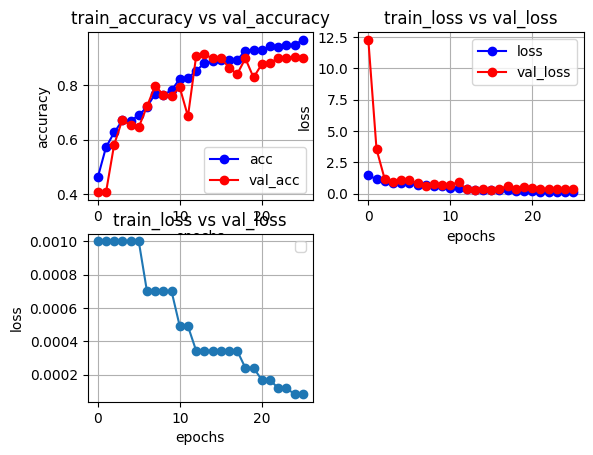

In [20]:
# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(history.epoch,history.history['lr'],'o-')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

## Modèle 2

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model2 = keras.models.Model(inputs=xception_model.input, outputs=output)

83683744/83683744 [==============================] - 47s 1us/step


In [11]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [12]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=10)



early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
mc =tf.keras.callbacks.ModelCheckpoint('XceptionLR_Xce2exp.h5', save_best_only=True)
class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.99):
                print("\nReached 99.0% accuracy so cancelling training!")
                self.model.stop_training = True

In [13]:
mycallback = CustomCallBack()
history1 = model2.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size,
            callbacks= [early_stopping_cb,mc,lr_scheduler,mycallback],
            verbose=1)

Epoch 1/30
221/221 [==============================] - 640s 3s/step - loss: 1.2286 - accuracy: 0.5628 - val_loss: 1.7062 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 2/30
221/221 [==============================] - 657s 3s/step - loss: 0.9546 - accuracy: 0.6629 - val_loss: 1.5295 - val_accuracy: 0.5183 - lr: 7.9433e-04
Epoch 3/30
221/221 [==============================] - 616s 3s/step - loss: 0.7607 - accuracy: 0.7268 - val_loss: 0.5729 - val_accuracy: 0.8110 - lr: 6.3096e-04
Epoch 4/30
221/221 [==============================] - 638s 3s/step - loss: 0.6459 - accuracy: 0.7805 - val_loss: 0.7524 - val_accuracy: 0.7195 - lr: 5.0119e-04
Epoch 5/30
221/221 [==============================] - 646s 3s/step - loss: 0.5228 - accuracy: 0.8196 - val_loss: 0.3539 - val_accuracy: 0.8720 - lr: 3.9811e-04
Epoch 6/30
221/221 [==============================] - 639s 3s/step - loss: 0.4475 - accuracy: 0.8445 - val_loss: 0.3831 - val_accuracy: 0.8659 - lr: 3.1623e-04
Epoch 7/30
221/221 [========================

In [29]:
# Pipeline
pipeline2 = Pipeline([
    ('xception2', model2)
])

In [30]:
# Save the pipeline to a joblib file
joblib.dump(pipeline2, 'xception2_pipeline.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
......activation_24
.........vars
......activation_25
.........vars
......activation_26
.........vars
......activation_27
.........vars
......activation_28
.........vars
......activation_29
.........vars
......activation_3
.........vars
......activation_30
.........vars
......activation_31
.........vars
......activation_32
.........vars
......activa

['xception2_pipeline.joblib']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


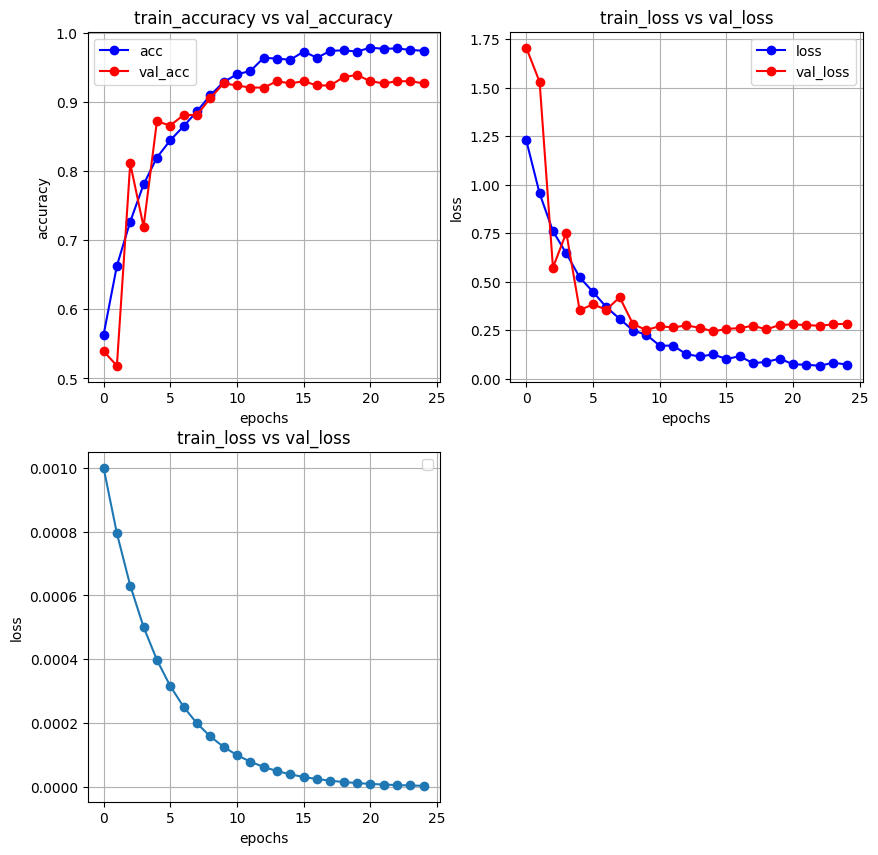

In [14]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history1.history['accuracy'],'bo-', label = "acc")
plt.plot(history1.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history1.history['loss'],'bo-', label = "loss")
plt.plot(history1.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(history1.epoch,history1.history['lr'],'o-')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [15]:
model2.evaluate(test_generator,batch_size = 1)

431/431 [==============================] - 59s 138ms/step - loss: 0.2262 - accuracy: 0.9466


[0.22621221840381622, 0.9466357231140137]

## YOLOv3 Model

In [ ]:
import os
import time
import cv2
import numpy as np
from yolo3.model import YOLO

In [ ]:
def process_image(img):
    """Resize, reduce and expand image.

    # Argument:
        img: original image.

    # Returns
        image: ndarray(64, 64, 3), processed image.
    """
    image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image /= 255.
    image = np.expand_dims(image, axis=0)

    return image

In [ ]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

In [ ]:
def draw(image, boxes, scores, classes, all_classes):
    """Draw the boxes on the image.

    # Argument:
        image: original image.
        boxes: ndarray, boxes of objects.
        classes: ndarray, classes of objects.
        scores: ndarray, scores of objects.
        all_classes: all classes name.
    """
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 1,
                    cv2.LINE_AA)

        print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
        print('box coordinate x,y,w,h: {0}'.format(box))

    print()

In [ ]:
def detect_image(image, yolo, all_classes):
    """Use yolo v3 to detect images.

    # Argument:
        image: original image.
        yolo: YOLO, yolo model.
        all_classes: all classes name.

    # Returns:
        image: processed image.
    """
    pimage = process_image(image)

    start = time.time()
    boxes, classes, scores = yolo.predict(pimage, image.shape)
    end = time.time()

    print('time: {0:.2f}s'.format(end - start))

    if boxes is not None:
        draw(image, boxes, scores, classes, all_classes)

    return (image, boxes)


def detect_video(video, yolo, all_classes):
    """Use yolo v3 to detect video.
    # Argument:
        video: video file.
        yolo: YOLO, yolo model.
        all_classes: all classes name.
    """
    video_path = os.path.join("videos", "test", video)
    camera = cv2.VideoCapture(video_path)
    cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

    # Prepare for saving the detected video
    sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')

    vout = cv2.VideoWriter()
    vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

    while True:
        res, frame = camera.read()

        if not res:
            break

        image = detect_image(frame, yolo, all_classes)
        cv2.imshow("detection", image)

        # Save the video frame by frame
        vout.write(image)

        if cv2.waitKey(110) & 0xff == 27:
                break

    vout.release()
    camera.release()

In [ ]:
if __name__ == '__main__':
    yolo = YOLO(0.6, 0.5)
    file = 'data/coco_classes.txt'
    all_classes = get_classes(file)
    
    f='/plas2.jpg'
    path ='images/test'+f
    image=cv2.imread(path)
    
    plt.imshow(image)
    (image,boxes)=detect_image(image,yolo,all_classes)
    cv2.imwrite('images/res/'+f,image)

In [ ]:
boxes=boxes.flatten()
x=boxes[0]
y=boxes[1]
w=boxes[2]
h=boxes[3]
boxed_image=image[(int(y)):(int(y+h)),(int(x)):(int(x+w)), :]

In [ ]:
boxed_image=cv2.cvtColor(boxed_image,cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(boxed_image)

In [ ]:
boxed_image_rescaled=boxed_image/255.

In [ ]:
boxed_image_rescaled=cv2.resize(boxed_image_rescaled,(150,150))

In [ ]:
new_boxed_im=cv2.resize(boxed_image,(150,150))

In [ ]:
new_boxed_im.shape

In [ ]:
from keras.preprocessing import image

In [ ]:
new_boxed_im=image.img_to_array(new_boxed_im)

In [ ]:
new_boxed_im=np.expand_dims(new_boxed_im,axis=0)
new_boxed_im=new_boxed_im/255.

In [ ]:
prediction=model2.predict(new_boxed_im)

In [ ]:
prediction

In [ ]:
train_generator.class_indices

In [ ]:
#detect videos one at a time in videos/test folder    
video = 'VID20210218073656.mp4'
detect_video(video, yolo, all_classes)